# Notebook 18: Uncertainty Quantification in Deep Learning

## Learning Objectives

By the end of this notebook, you will:
1. Understand aleatoric vs epistemic uncertainty
2. Implement MC Dropout for uncertainty estimation
3. Build and use Deep Ensembles
4. Create heteroscedastic networks that predict variance
5. Understand Bayesian Neural Networks basics
6. Evaluate model calibration

**Prerequisites**: Notebooks 01-04 (PyTorch fundamentals, training loops)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


---
## 1. Why Uncertainty Matters

Standard neural networks output point predictions without indicating confidence. This is problematic:

- **Safety-critical applications**: Medical diagnosis, autonomous vehicles
- **Out-of-distribution (OOD) detection**: Knowing when inputs are unlike training data
- **Active learning**: Selecting informative samples to label
- **Decision making**: When to defer to humans

In [3]:
# Demonstration: overconfident predictions
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        return self.net(x.view(-1, 784))

# Load MNIST
transform = transforms.ToTensor()
mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('../data', train=False, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=128)

# Quick training
model = SimpleNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        loss = F.cross_entropy(model(x), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

print("Model trained on MNIST")

Model trained on MNIST


In [4]:
# Test on MNIST (in-distribution) vs random noise (OOD)
model.eval()

# In-distribution
x_id, _ = next(iter(test_loader))
x_id = x_id[:5].to(device)

# Out-of-distribution: random noise
x_ood = torch.rand(5, 1, 28, 28).to(device)

with torch.no_grad():
    probs_id = F.softmax(model(x_id), dim=1)
    probs_ood = F.softmax(model(x_ood), dim=1)

print("In-distribution (MNIST) - Max confidence:")
print(probs_id.max(dim=1).values.cpu().numpy())

print("\nOut-of-distribution (noise) - Max confidence:")
print(probs_ood.max(dim=1).values.cpu().numpy())
print("\n→ The model is equally confident on random noise!")

In-distribution (MNIST) - Max confidence:
[0.99985325 0.99979    0.9900946  0.99870753 0.9991715 ]

Out-of-distribution (noise) - Max confidence:
[0.66397595 0.80766416 0.9372803  0.92569363 0.7719611 ]

→ The model is equally confident on random noise!


---
## 2. Types of Uncertainty

### Aleatoric Uncertainty (Data Uncertainty)
- Inherent noise in the data
- **Irreducible** - more data won't help
- Example: Noisy sensor measurements, ambiguous labels

### Epistemic Uncertainty (Model Uncertainty)
- Uncertainty due to limited knowledge/data
- **Reducible** - more data helps
- Example: Predictions far from training distribution

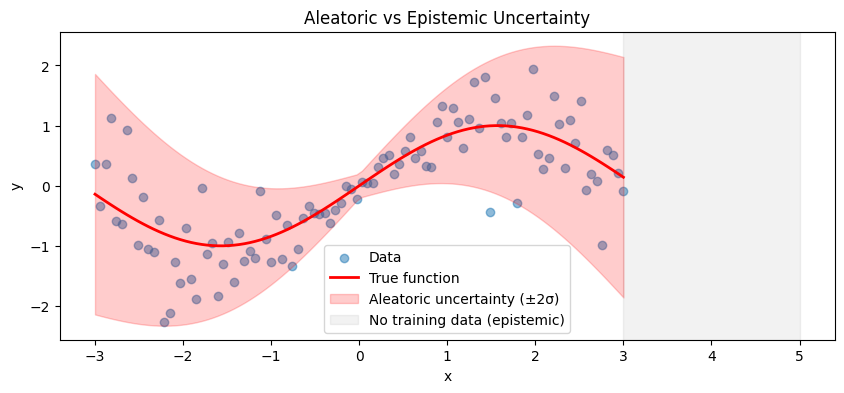

In [5]:
# Visualize both types with a regression example
def generate_regression_data(n=100):
    """Generate data with heteroscedastic noise (varying aleatoric uncertainty)."""
    x = np.linspace(-3, 3, n)
    # Noise increases with x (heteroscedastic)
    noise_std = 0.1 + 0.3 * np.abs(x)
    y = np.sin(x) + np.random.randn(n) * noise_std
    return x.astype(np.float32), y.astype(np.float32), noise_std

x_train, y_train, true_noise = generate_regression_data(100)

plt.figure(figsize=(10, 4))
plt.scatter(x_train, y_train, alpha=0.5, label='Data')
plt.plot(x_train, np.sin(x_train), 'r-', label='True function', linewidth=2)
plt.fill_between(x_train, np.sin(x_train) - 2*true_noise, 
                 np.sin(x_train) + 2*true_noise, alpha=0.2, color='red',
                 label='Aleatoric uncertainty (±2σ)')
plt.axvspan(3, 5, alpha=0.1, color='gray', label='No training data (epistemic)')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Aleatoric vs Epistemic Uncertainty')
plt.show()

---
## 3. MC Dropout: Simple Uncertainty Estimation

**Key insight**: Dropout at test time approximates Bayesian inference!

Instead of disabling dropout during inference:
1. Keep dropout **enabled**
2. Run multiple forward passes
3. Use variance of predictions as uncertainty

In [6]:
class MCDropoutNet(nn.Module):
    """Network with dropout that stays on during inference."""
    
    def __init__(self, dropout_p=0.2):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout_p)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.dropout(self.fc1(x)))
        x = F.relu(self.dropout(self.fc2(x)))
        return self.fc3(x)
    
    def predict_with_uncertainty(self, x, n_samples=50):
        """Run multiple forward passes with dropout enabled."""
        self.train()  # Keep dropout active
        
        predictions = []
        with torch.no_grad():
            for _ in range(n_samples):
                logits = self(x)
                probs = F.softmax(logits, dim=1)
                predictions.append(probs)
        
        predictions = torch.stack(predictions)  # [n_samples, batch, classes]
        
        # Mean prediction
        mean_pred = predictions.mean(dim=0)
        
        # Uncertainty: predictive entropy or variance
        variance = predictions.var(dim=0)  # Variance per class
        entropy = -(mean_pred * torch.log(mean_pred + 1e-10)).sum(dim=1)
        
        return mean_pred, entropy, variance

In [7]:
# Train MC Dropout model
mc_model = MCDropoutNet(dropout_p=0.3).to(device)
optimizer = torch.optim.Adam(mc_model.parameters(), lr=1e-3)

for epoch in range(10):
    mc_model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        loss = F.cross_entropy(mc_model(x), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

print("MC Dropout model trained")

MC Dropout model trained


In [8]:
# Compare uncertainty on ID vs OOD
mean_id, entropy_id, _ = mc_model.predict_with_uncertainty(x_id, n_samples=50)
mean_ood, entropy_ood, _ = mc_model.predict_with_uncertainty(x_ood, n_samples=50)

print("MC Dropout Uncertainty (entropy):")
print(f"In-distribution:  {entropy_id.cpu().numpy()}")
print(f"Out-of-distribution: {entropy_ood.cpu().numpy()}")
print(f"\n→ Higher entropy on OOD data indicates uncertainty!")

MC Dropout Uncertainty (entropy):
In-distribution:  [0.0139045  0.0121435  0.00608451 0.00531002 0.03569035]
Out-of-distribution: [1.1727087  0.8265209  1.161003   0.77940154 1.1569874 ]

→ Higher entropy on OOD data indicates uncertainty!


ID sample:


/tmp/ipykernel_13133/1087869677.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(predictions, labels=range(10))


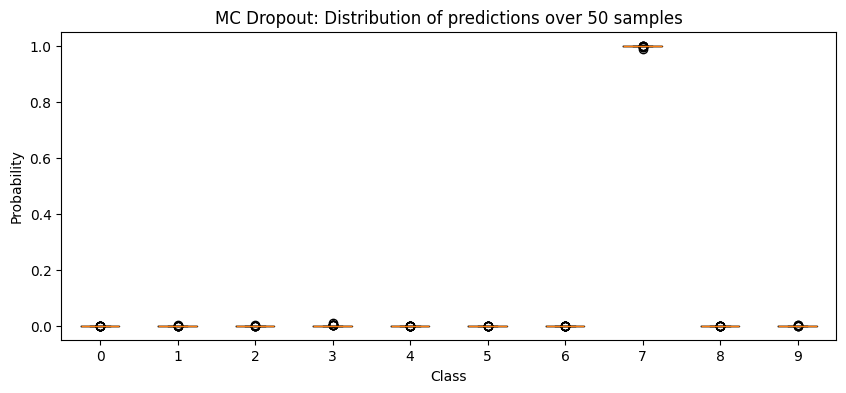

OOD sample (noise):


/tmp/ipykernel_13133/1087869677.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(predictions, labels=range(10))


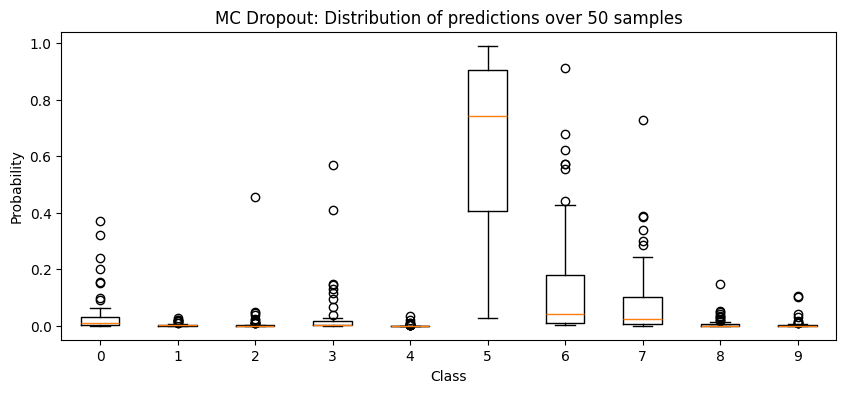

In [9]:
# Visualize MC Dropout predictions
def visualize_mc_dropout(model, x, n_samples=50):
    model.train()
    predictions = []
    with torch.no_grad():
        for _ in range(n_samples):
            probs = F.softmax(model(x), dim=1)
            predictions.append(probs[0].cpu().numpy())
    
    predictions = np.array(predictions)
    
    plt.figure(figsize=(10, 4))
    plt.boxplot(predictions, labels=range(10))
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title('MC Dropout: Distribution of predictions over 50 samples')
    plt.show()

print("ID sample:")
visualize_mc_dropout(mc_model, x_id[0:1])

print("OOD sample (noise):")
visualize_mc_dropout(mc_model, x_ood[0:1])

---
## 4. Deep Ensembles

Train multiple models independently, aggregate their predictions.

**Advantages over MC Dropout:**
- Often better uncertainty estimates
- Each model sees full capacity (no dropout)
- Embarrassingly parallel training

**Disadvantages:**
- N× training cost
- N× memory for inference

In [10]:
class DeepEnsemble:
    """Ensemble of independently trained models."""
    
    def __init__(self, model_class, n_models=5, **model_kwargs):
        self.models = [model_class(**model_kwargs) for _ in range(n_models)]
        self.n_models = n_models
    
    def to(self, device):
        for model in self.models:
            model.to(device)
        return self
    
    def train_all(self, train_loader, epochs=10, lr=1e-3):
        """Train each model independently."""
        for i, model in enumerate(self.models):
            print(f"Training model {i+1}/{self.n_models}")
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            
            for epoch in range(epochs):
                model.train()
                for x, y in train_loader:
                    x, y = x.to(device), y.to(device)
                    loss = F.cross_entropy(model(x), y)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
    
    def predict_with_uncertainty(self, x):
        """Aggregate predictions from all models."""
        predictions = []
        
        for model in self.models:
            model.eval()
            with torch.no_grad():
                probs = F.softmax(model(x), dim=1)
                predictions.append(probs)
        
        predictions = torch.stack(predictions)  # [n_models, batch, classes]
        
        mean_pred = predictions.mean(dim=0)
        variance = predictions.var(dim=0)
        entropy = -(mean_pred * torch.log(mean_pred + 1e-10)).sum(dim=1)
        
        return mean_pred, entropy, variance

In [11]:
# Train ensemble
ensemble = DeepEnsemble(SimpleNet, n_models=5).to(device)
ensemble.train_all(train_loader, epochs=5)

Training model 1/5
Training model 2/5
Training model 3/5
Training model 4/5
Training model 5/5


In [12]:
# Compare ensemble uncertainty
mean_id_ens, entropy_id_ens, _ = ensemble.predict_with_uncertainty(x_id)
mean_ood_ens, entropy_ood_ens, _ = ensemble.predict_with_uncertainty(x_ood)

print("Deep Ensemble Uncertainty (entropy):")
print(f"In-distribution:  {entropy_id_ens.cpu().numpy()}")
print(f"Out-of-distribution: {entropy_ood_ens.cpu().numpy()}")

Deep Ensemble Uncertainty (entropy):
In-distribution:  [0.00179467 0.00298525 0.0238749  0.00191722 0.02597691]
Out-of-distribution: [1.0596633  1.0505483  0.96866    0.84758794 0.84207416]


In [13]:
# Compare MC Dropout vs Ensemble on OOD detection
def evaluate_ood_detection(id_entropy, ood_entropy):
    """Simple evaluation: can we separate ID from OOD using entropy?"""
    id_vals = id_entropy.cpu().numpy()
    ood_vals = ood_entropy.cpu().numpy()
    
    threshold = (id_vals.mean() + ood_vals.mean()) / 2
    
    id_correct = (id_vals < threshold).mean()
    ood_correct = (ood_vals >= threshold).mean()
    
    return (id_correct + ood_correct) / 2

# Evaluate on larger set
x_id_large = next(iter(test_loader))[0][:100].to(device)
x_ood_large = torch.rand(100, 1, 28, 28).to(device)

_, ent_id_mc, _ = mc_model.predict_with_uncertainty(x_id_large, n_samples=30)
_, ent_ood_mc, _ = mc_model.predict_with_uncertainty(x_ood_large, n_samples=30)

_, ent_id_ens, _ = ensemble.predict_with_uncertainty(x_id_large)
_, ent_ood_ens, _ = ensemble.predict_with_uncertainty(x_ood_large)

print(f"OOD Detection Accuracy:")
print(f"MC Dropout: {evaluate_ood_detection(ent_id_mc, ent_ood_mc):.2%}")
print(f"Ensemble:   {evaluate_ood_detection(ent_id_ens, ent_ood_ens):.2%}")

OOD Detection Accuracy:
MC Dropout: 93.50%
Ensemble:   94.00%


---
## 5. Heteroscedastic Networks: Learning Aleatoric Uncertainty

Instead of predicting just the mean, predict **both mean and variance**.

For regression: $p(y|x) = \mathcal{N}(\mu(x), \sigma^2(x))$

Loss: Negative log-likelihood
$$\mathcal{L} = \frac{1}{2\sigma^2}(y - \mu)^2 + \frac{1}{2}\log\sigma^2$$

In [14]:
class HeteroscedasticNet(nn.Module):
    """Network that predicts mean and variance."""
    
    def __init__(self, input_dim=1, hidden_dim=64):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.mean_head = nn.Linear(hidden_dim, 1)
        self.logvar_head = nn.Linear(hidden_dim, 1)  # Log variance for stability
    
    def forward(self, x):
        h = self.shared(x)
        mean = self.mean_head(h)
        logvar = self.logvar_head(h)
        return mean, logvar


def heteroscedastic_loss(y_true, mean, logvar):
    """Negative log-likelihood for Gaussian with predicted variance."""
    precision = torch.exp(-logvar)
    return torch.mean(0.5 * precision * (y_true - mean)**2 + 0.5 * logvar)

In [15]:
# Prepare regression data
x_tensor = torch.tensor(x_train).unsqueeze(1)
y_tensor = torch.tensor(y_train).unsqueeze(1)
reg_dataset = TensorDataset(x_tensor, y_tensor)
reg_loader = DataLoader(reg_dataset, batch_size=32, shuffle=True)

# Train heteroscedastic model
het_model = HeteroscedasticNet().to(device)
optimizer = torch.optim.Adam(het_model.parameters(), lr=1e-2)

for epoch in range(500):
    for x_batch, y_batch in reg_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        mean, logvar = het_model(x_batch)
        loss = heteroscedastic_loss(y_batch, mean, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

print("Heteroscedastic model trained")

Heteroscedastic model trained


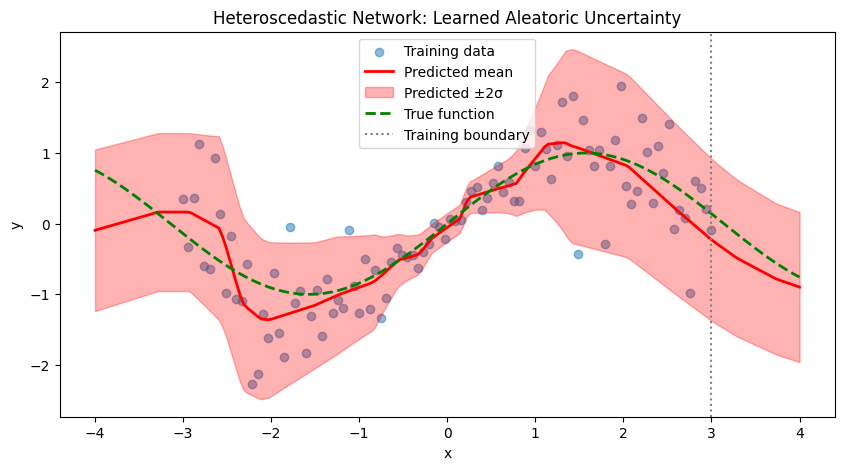

Note: Model learns higher variance where data is noisier
But uncertainty doesn't increase much outside training range (epistemic!)


In [16]:
# Visualize learned uncertainty
het_model.eval()
x_test = torch.linspace(-4, 4, 200).unsqueeze(1).to(device)

with torch.no_grad():
    mean_pred, logvar_pred = het_model(x_test)
    std_pred = torch.exp(0.5 * logvar_pred)

x_np = x_test.cpu().numpy().squeeze()
mean_np = mean_pred.cpu().numpy().squeeze()
std_np = std_pred.cpu().numpy().squeeze()

plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, alpha=0.5, label='Training data')
plt.plot(x_np, mean_np, 'r-', label='Predicted mean', linewidth=2)
plt.fill_between(x_np, mean_np - 2*std_np, mean_np + 2*std_np, 
                 alpha=0.3, color='red', label='Predicted ±2σ')
plt.plot(x_np, np.sin(x_np), 'g--', label='True function', linewidth=2)
plt.axvline(x=3, color='gray', linestyle=':', label='Training boundary')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heteroscedastic Network: Learned Aleatoric Uncertainty')
plt.show()

print("Note: Model learns higher variance where data is noisier")
print("But uncertainty doesn't increase much outside training range (epistemic!)")

---
## 6. Combining Methods: Epistemic + Aleatoric

Use ensembles of heteroscedastic networks to capture both types.

In [17]:
class HeteroscedasticEnsemble:
    """Ensemble of heteroscedastic models for both uncertainty types."""
    
    def __init__(self, n_models=5):
        self.models = [HeteroscedasticNet() for _ in range(n_models)]
        self.n_models = n_models
    
    def to(self, device):
        for m in self.models:
            m.to(device)
        return self
    
    def train_all(self, loader, epochs=500, lr=1e-2):
        for i, model in enumerate(self.models):
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            for epoch in range(epochs):
                for x, y in loader:
                    x, y = x.to(device), y.to(device)
                    mean, logvar = model(x)
                    loss = heteroscedastic_loss(y, mean, logvar)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            print(f"Model {i+1}/{self.n_models} trained")
    
    def predict(self, x):
        means, variances = [], []
        for model in self.models:
            model.eval()
            with torch.no_grad():
                mean, logvar = model(x)
                means.append(mean)
                variances.append(torch.exp(logvar))
        
        means = torch.stack(means)
        variances = torch.stack(variances)
        
        # Total uncertainty decomposition
        mean_pred = means.mean(dim=0)
        aleatoric = variances.mean(dim=0)  # Average predicted variance
        epistemic = means.var(dim=0)       # Variance of means
        total = aleatoric + epistemic
        
        return mean_pred, aleatoric, epistemic, total

In [18]:
# Train ensemble
het_ensemble = HeteroscedasticEnsemble(n_models=5).to(device)
het_ensemble.train_all(reg_loader, epochs=300)

Model 1/5 trained
Model 2/5 trained
Model 3/5 trained
Model 4/5 trained
Model 5/5 trained


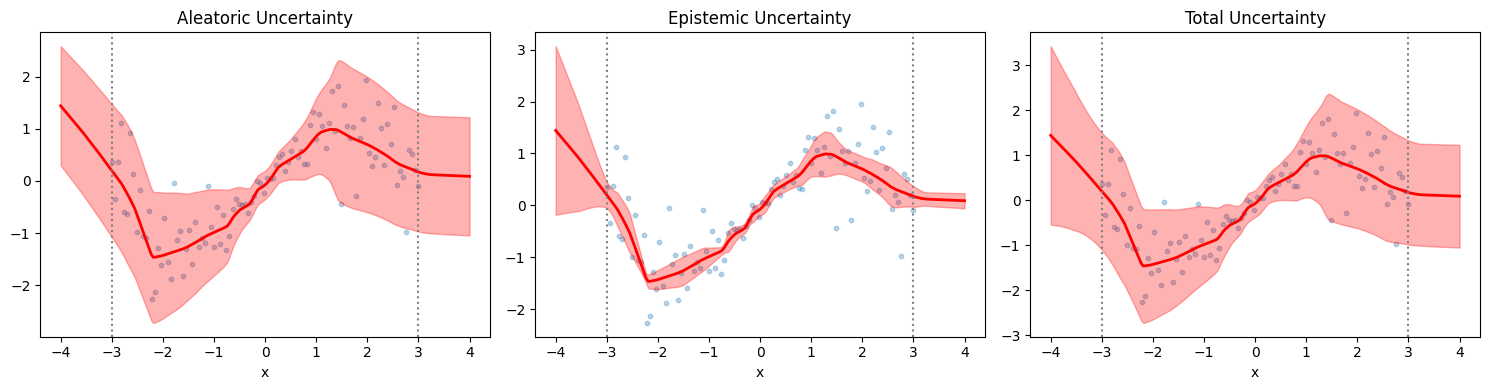

Observations:
- Aleatoric: Higher where data is noisier (center-right)
- Epistemic: Higher outside training range (extrapolation)
- Total: Combines both sources


In [19]:
# Visualize decomposed uncertainty
mean_pred, aleatoric, epistemic, total = het_ensemble.predict(x_test)

mean_np = mean_pred.cpu().numpy().squeeze()
ale_np = np.sqrt(aleatoric.cpu().numpy().squeeze())
epi_np = np.sqrt(epistemic.cpu().numpy().squeeze())
tot_np = np.sqrt(total.cpu().numpy().squeeze())

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (unc, name) in zip(axes, [(ale_np, 'Aleatoric'), (epi_np, 'Epistemic'), (tot_np, 'Total')]):
    ax.scatter(x_train, y_train, alpha=0.3, s=10)
    ax.plot(x_np, mean_np, 'r-', linewidth=2)
    ax.fill_between(x_np, mean_np - 2*unc, mean_np + 2*unc, alpha=0.3, color='red')
    ax.axvline(x=3, color='gray', linestyle=':')
    ax.axvline(x=-3, color='gray', linestyle=':')
    ax.set_title(f'{name} Uncertainty')
    ax.set_xlabel('x')

plt.tight_layout()
plt.show()

print("Observations:")
print("- Aleatoric: Higher where data is noisier (center-right)")
print("- Epistemic: Higher outside training range (extrapolation)")
print("- Total: Combines both sources")

---
## 7. Bayesian Neural Networks (Introduction)

Instead of point estimates for weights, learn **distributions** over weights.

### Bayes by Backprop
- Weights: $w \sim q_\theta(w) = \mathcal{N}(\mu, \sigma^2)$
- Learn $\mu$ and $\sigma$ via variational inference
- Loss: $\mathcal{L} = \text{KL}(q(w) \| p(w)) - \mathbb{E}_{q(w)}[\log p(D|w)]$

In [42]:
class BayesianLinear(nn.Module):
    """Linear layer with weight uncertainty (Bayes by Backprop)."""
    
    def __init__(self, in_features, out_features, prior_std=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Weight mean and log variance (rho parameterization)
        self.weight_mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_rho = nn.Parameter(torch.zeros(out_features, in_features) - 3)
        
        # Bias
        self.bias_mu = nn.Parameter(torch.zeros(out_features))
        self.bias_rho = nn.Parameter(torch.zeros(out_features) - 3)
        
        # Prior
        self.prior_std = prior_std
        
        # Initialize
        nn.init.kaiming_normal_(self.weight_mu)
    
    def forward(self, x):
        # Reparameterization: sigma = log(1 + exp(rho))
        weight_sigma = F.softplus(self.weight_rho)
        bias_sigma = F.softplus(self.bias_rho)
        
        # Sample weights
        weight = self.weight_mu + weight_sigma * torch.randn_like(weight_sigma)
        bias = self.bias_mu + bias_sigma * torch.randn_like(bias_sigma)
        
        return F.linear(x, weight, bias)
    
    def kl_divergence(self):
        """KL divergence from posterior to prior."""
        weight_sigma = F.softplus(self.weight_rho)
        bias_sigma = F.softplus(self.bias_rho)
        
        # KL for Gaussian: 0.5 * (sigma^2/prior^2 + mu^2/prior^2 - 1 - log(sigma^2/prior^2))
        kl_weight = 0.5 * (weight_sigma**2 / self.prior_std**2 + 
                          self.weight_mu**2 / self.prior_std**2 - 1 - 
                          torch.log(weight_sigma**2 / self.prior_std**2))
        kl_bias = 0.5 * (bias_sigma**2 / self.prior_std**2 + 
                        self.bias_mu**2 / self.prior_std**2 - 1 - 
                        torch.log(bias_sigma**2 / self.prior_std**2))
        
        return kl_weight.sum() + kl_bias.sum()

In [43]:
class BayesianNet(nn.Module):
    """Simple Bayesian neural network."""
    
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10):
        super().__init__()
        self.fc1 = BayesianLinear(input_dim, hidden_dim)
        self.fc2 = BayesianLinear(hidden_dim, hidden_dim)
        self.fc3 = BayesianLinear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
    def kl_divergence(self):
        return self.fc1.kl_divergence() + self.fc2.kl_divergence() + self.fc3.kl_divergence()
    
    def predict_with_uncertainty(self, x, n_samples=30):
        predictions = []
        for _ in range(n_samples):
            probs = F.softmax(self(x), dim=1)
            predictions.append(probs)
        
        predictions = torch.stack(predictions)
        mean_pred = predictions.mean(dim=0)
        entropy = -(mean_pred * torch.log(mean_pred + 1e-10)).sum(dim=1)
        
        return mean_pred, entropy

In [44]:
# Train BNN
bnn = BayesianNet().to(device)
optimizer = torch.optim.Adam(bnn.parameters(), lr=1e-3)
n_batches = len(train_loader)

for epoch in range(10):
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        # ELBO loss: NLL + KL / n_batches
        logits = bnn(x)
        nll = F.cross_entropy(logits, y)
        kl = bnn.kl_divergence() / (n_batches * x.size(0))
        loss = nll + kl
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/n_batches:.4f}")

Epoch 5, Loss: 3.4218
Epoch 10, Loss: 2.4009


In [53]:
# Compare BNN uncertainty
bnn.eval()
mean_id_bnn, entropy_id_bnn = bnn.predict_with_uncertainty(x_id)
mean_ood_bnn, entropy_ood_bnn = bnn.predict_with_uncertainty(x_ood)

print("BNN Uncertainty (entropy):")
print(f"In-distribution:  {entropy_id_bnn.detach().cpu().numpy()}")
print(f"Out-of-distribution: {entropy_ood_bnn.detach().cpu().numpy()}")

BNN Uncertainty (entropy):
In-distribution:  [0.0018366  0.00213071 0.0145484  0.00173846 0.11961659]
Out-of-distribution: [1.8193867 1.7355435 1.6950821 1.9445179 1.7956754]


---
## 8. Model Calibration

A model is **calibrated** if its confidence matches its accuracy.

If model says 80% confident → should be correct 80% of the time.

In [46]:
# def compute_calibration(model, loader, n_bins=10, mc_samples=None):
#     """Compute Expected Calibration Error and reliability diagram data."""
#     confidences, accuracies, predictions = [], [], []
    
#     model.eval()
#     with torch.no_grad():
#         for x, y in loader:
#             x, y = x.to(device), y.to(device)
            
#             if mc_samples and hasattr(model, 'predict_with_uncertainty'):
#                 probs, _ = model.predict_with_uncertainty(x, n_samples=mc_samples)
#             else:
#                 probs = F.softmax(model(x), dim=1)
            
#             conf, pred = probs.max(dim=1)
#             correct = (pred == y).float()
            
#             confidences.extend(conf.cpu().numpy())
#             accuracies.extend(correct.cpu().numpy())
#             predictions.extend(pred.cpu().numpy())
    
#     confidences = np.array(confidences)
#     accuracies = np.array(accuracies)
    
#     # Bin by confidence
#     bin_boundaries = np.linspace(0, 1, n_bins + 1)
#     bin_accs, bin_confs, bin_counts = [], [], []
    
#     for i in range(n_bins):
#         mask = (confidences > bin_boundaries[i]) & (confidences <= bin_boundaries[i+1])
#         if mask.sum() > 0:
#             bin_accs.append(accuracies[mask].mean())
#             bin_confs.append(confidences[mask].mean())
#             bin_counts.append(mask.sum())
#         else:
#             bin_accs.append(0)
#             bin_confs.append((bin_boundaries[i] + bin_boundaries[i+1]) / 2)
#             bin_counts.append(0)
    
#     # ECE: weighted average of |accuracy - confidence|
#     ece = sum(c * abs(a - cf) for a, cf, c in zip(bin_accs, bin_confs, bin_counts)) / sum(bin_counts)
    
#     return ece, bin_accs, bin_confs, bin_counts

In [54]:
def compute_calibration(model, loader, n_bins=10, mc_samples=None):
    """Compute Expected Calibration Error and reliability diagram data."""
    confidences, accuracies, predictions = [], [], []
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            
            if mc_samples and hasattr(model, 'predict_with_uncertainty'):
                result = model.predict_with_uncertainty(x, n_samples=mc_samples)
                # MCDropoutNet returns 3 values, BayesianNet returns 2
                probs = result[0]  # First value is always mean_pred
            else:
                probs = F.softmax(model(x), dim=1)
            
            conf, pred = probs.max(dim=1)
            correct = (pred == y).float()
            
            confidences.extend(conf.cpu().numpy())
            accuracies.extend(correct.cpu().numpy())
            predictions.extend(pred.cpu().numpy())
    
    confidences = np.array(confidences)
    accuracies = np.array(accuracies)
    
    # Bin by confidence
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_accs, bin_confs, bin_counts = [], [], []
    
    for i in range(n_bins):
        mask = (confidences > bin_boundaries[i]) & (confidences <= bin_boundaries[i+1])
        if mask.sum() > 0:
            bin_accs.append(accuracies[mask].mean())
            bin_confs.append(confidences[mask].mean())
            bin_counts.append(mask.sum())
        else:
            bin_accs.append(0)
            bin_confs.append((bin_boundaries[i] + bin_boundaries[i+1]) / 2)
            bin_counts.append(0)
    
    # ECE: weighted average of |accuracy - confidence|
    ece = sum(c * abs(a - cf) for a, cf, c in zip(bin_accs, bin_confs, bin_counts)) / sum(bin_counts)
    
    return ece, bin_accs, bin_confs, bin_counts

In [ ]:
# def compute_calibration(model, loader, n_bins=10, mc_samples=None):
#     """Compute Expected Calibration Error and reliability diagram data."""
#     confidences, accuracies, predictions = [], [], []
#     model.eval()
    
#     with torch.no_grad():
#         for x, y in loader:
#             x, y = x.to(device), y.to(device)
            
#             if mc_samples and hasattr(model, 'predict_with_uncertainty'):
#                 result = model.predict_with_uncertainty(x, n_samples=mc_samples)
#                 # Handle both 2 and 3 return values
#                 if len(result) == 3:
#                     probs, _, _ = result  # Unpack 3 values
#                 elif len(result) == 2:
#                     probs, _ = result  # Unpack 2 values
#                 else:
#                     probs = result[0]  # Fallback
#             else:
#                 probs = F.softmax(model(x), dim=1)
            
#             conf, pred = probs.max(dim=1)
#             correct = (pred == y).float()
            
#             confidences.extend(conf.cpu().numpy())
#             accuracies.extend(correct.cpu().numpy())
#             predictions.extend(pred.cpu().numpy())
    
#     confidences = np.array(confidences)
#     accuracies = np.array(accuracies)
    
#     # Bin by confidence
#     bin_boundaries = np.linspace(0, 1, n_bins + 1)
#     bin_accs, bin_confs, bin_counts = [], [], []
    
#     for i in range(n_bins):
#         mask = (confidences > bin_boundaries[i]) & (confidences <= bin_boundaries[i+1])
#         if mask.sum() > 0:
#             bin_accs.append(accuracies[mask].mean())
#             bin_confs.append(confidences[mask].mean())
#             bin_counts.append(mask.sum())
#         else:
#             bin_accs.append(0)
#             bin_confs.append((bin_boundaries[i] + bin_boundaries[i+1]) / 2)
#             bin_counts.append(0)
    
#     # ECE: weighted average of |accuracy - confidence|
#     ece = sum(c * abs(a - cf) for a, cf, c in zip(bin_accs, bin_confs, bin_counts)) / sum(bin_counts)
    
#     return ece, bin_accs, bin_confs, bin_counts

Computing calibration...


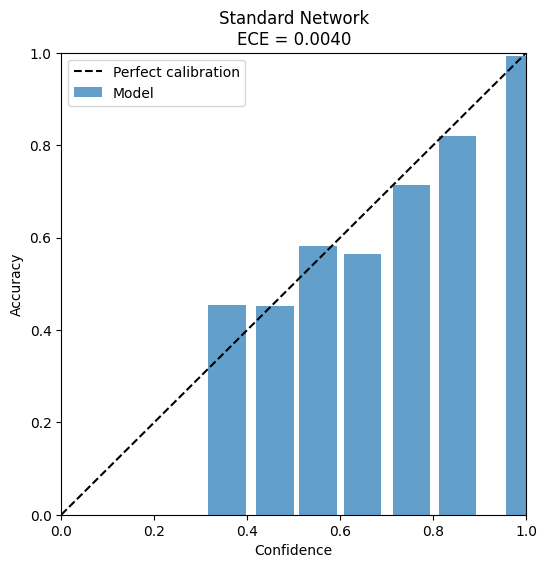

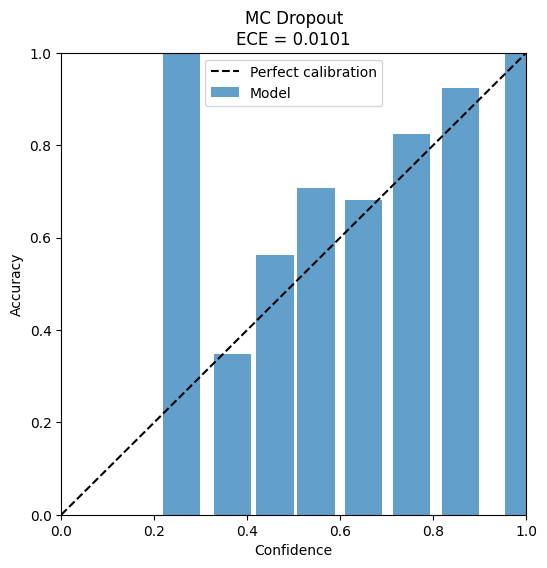

In [55]:
def plot_reliability_diagram(bin_accs, bin_confs, ece, title):
    """Plot reliability diagram."""
    plt.figure(figsize=(6, 6))
    
    # Perfect calibration line
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    
    # Bar chart
    width = 0.08
    plt.bar(bin_confs, bin_accs, width=width, alpha=0.7, label='Model')
    
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title(f'{title}\nECE = {ece:.4f}')
    plt.legend()
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()

# Compare calibration
print("Computing calibration...")

ece_simple, acc_s, conf_s, _ = compute_calibration(model, test_loader)
ece_mc, acc_mc, conf_mc, _ = compute_calibration(mc_model, test_loader, mc_samples=30)

plot_reliability_diagram(acc_s, conf_s, ece_simple, 'Standard Network')
plot_reliability_diagram(acc_mc, conf_mc, ece_mc, 'MC Dropout')

### Temperature Scaling

Simple post-hoc calibration: divide logits by learned temperature T.

In [50]:
class TemperatureScaling(nn.Module):
    """Post-hoc calibration via temperature scaling."""
    
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1))
    
    def forward(self, x):
        logits = self.model(x)
        return logits / self.temperature
    
    def calibrate(self, val_loader, lr=0.01, epochs=50):
        """Learn temperature on validation set."""
        self.model.eval()
        optimizer = torch.optim.LBFGS([self.temperature], lr=lr, max_iter=epochs)
        
        # Collect all logits and labels
        logits_list, labels_list = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits_list.append(self.model(x))
                labels_list.append(y)
        
        all_logits = torch.cat(logits_list)
        all_labels = torch.cat(labels_list)
        
        def closure():
            optimizer.zero_grad()
            loss = F.cross_entropy(all_logits / self.temperature, all_labels)
            loss.backward()
            return loss
        
        optimizer.step(closure)
        print(f"Learned temperature: {self.temperature.item():.4f}")

Learned temperature: 1.0369

ECE before temperature scaling: 0.0039
ECE after temperature scaling:  0.0035


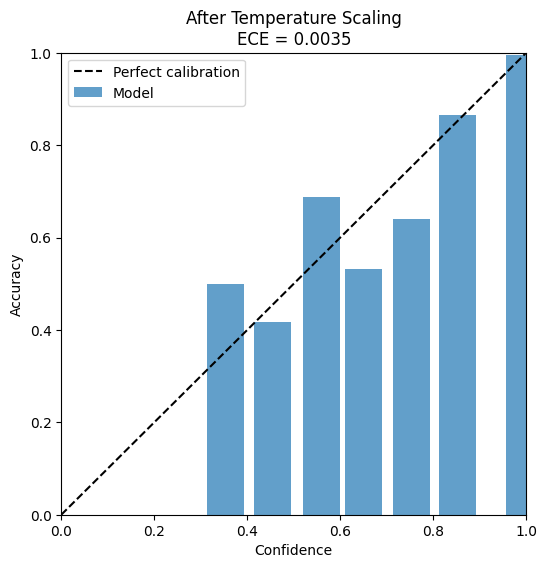

In [35]:
# Apply temperature scaling
# Use part of test set as validation
val_loader = DataLoader(Subset(mnist_test, range(5000)), batch_size=128)
test_loader_half = DataLoader(Subset(mnist_test, range(5000, 10000)), batch_size=128)

temp_model = TemperatureScaling(model).to(device)
temp_model.calibrate(val_loader)

# Compare calibration
ece_temp, acc_t, conf_t, _ = compute_calibration(temp_model, test_loader_half)
ece_orig, acc_o, conf_o, _ = compute_calibration(model, test_loader_half)

print(f"\nECE before temperature scaling: {ece_orig:.4f}")
print(f"ECE after temperature scaling:  {ece_temp:.4f}")

plot_reliability_diagram(acc_t, conf_t, ece_temp, 'After Temperature Scaling')

---
## 9. Summary

### Methods Comparison

| Method | Captures | Compute Cost | Memory | Quality |
|--------|----------|--------------|--------|--------|
| MC Dropout | Epistemic | N forward passes | 1× | Good |
| Deep Ensemble | Epistemic | N× training | N× | Best |
| Heteroscedastic | Aleatoric | 1× | 1× | Good |
| BNN | Both | N forward passes | ~2× | Variable |
| Temperature Scaling | Calibration only | 1× | 1× | Limited |

### When to Use What

- **MC Dropout**: Quick uncertainty with minimal changes
- **Deep Ensemble**: Best uncertainty, if compute allows
- **Heteroscedastic**: When data has varying noise
- **BNN**: Research, principled uncertainty
- **Temperature Scaling**: Quick calibration fix

### Key Takeaways

1. **Aleatoric** = data noise (irreducible), **Epistemic** = model uncertainty (reducible)
2. Softmax confidence ≠ calibrated probability
3. Ensembles are simple and effective
4. Always evaluate calibration (ECE, reliability diagrams)

---
## Exercises

### Exercise 1: OOD Detection with Fashion-MNIST
Train on MNIST, test uncertainty on Fashion-MNIST. Compare MC Dropout vs Ensemble.

### Exercise 2: Uncertainty-Aware Prediction
Build a classifier that abstains (outputs "unknown") when uncertainty is high. Measure accuracy vs coverage trade-off.

### Exercise 3: Active Learning Simulation
Start with 100 labeled samples. Use uncertainty to select which samples to label next. Compare to random selection.

---
## Solutions

OOD Detection AUROC (MNIST vs Fashion-MNIST):
MC Dropout: 0.8984
Ensemble:   0.8525


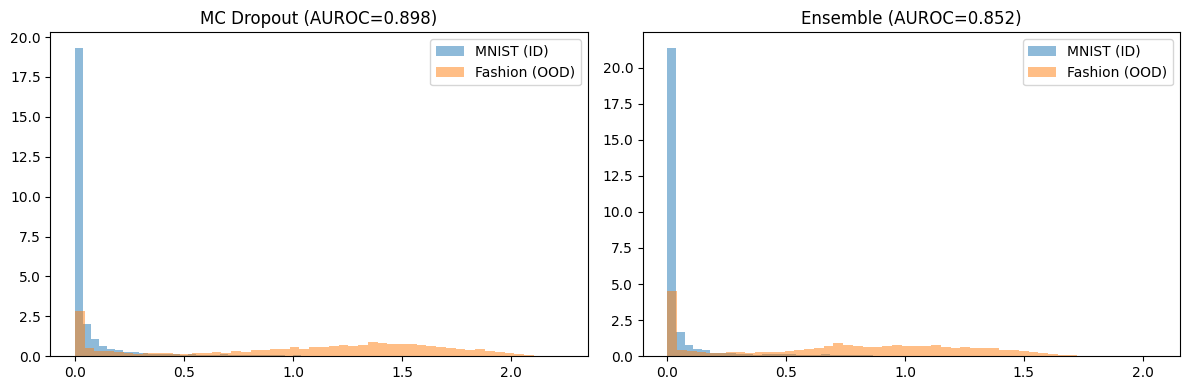

In [56]:
# Solution 1: OOD Detection with Fashion-MNIST
fashion_test = datasets.FashionMNIST('../data', train=False, download=True, transform=transform)
fashion_loader = DataLoader(fashion_test, batch_size=128)

# def evaluate_ood(model, id_loader, ood_loader, method='mc', n_samples=30):
#     """Evaluate OOD detection using entropy."""
#     id_entropies, ood_entropies = [], []
    
#     # ID data
#     for x, _ in id_loader:
#         x = x.to(device)
#         if method == 'mc' and hasattr(model, 'predict_with_uncertainty'):
#             _, entropy = model.predict_with_uncertainty(x, n_samples=n_samples)
#         elif method == 'ensemble':
#             _, entropy, _ = model.predict_with_uncertainty(x)
#         else:
#             with torch.no_grad():
#                 probs = F.softmax(model(x), dim=1)
#                 entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1)
#         id_entropies.extend(entropy.cpu().numpy())
    
#     # OOD data
#     for x, _ in ood_loader:
#         x = x.to(device)
#         if method == 'mc' and hasattr(model, 'predict_with_uncertainty'):
#             _, entropy = model.predict_with_uncertainty(x, n_samples=n_samples)
#         elif method == 'ensemble':
#             _, entropy, _ = model.predict_with_uncertainty(x)
#         else:
#             with torch.no_grad():
#                 probs = F.softmax(model(x), dim=1)
#                 entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1)
#         ood_entropies.extend(entropy.cpu().numpy())
    
#     id_entropies = np.array(id_entropies)
#     ood_entropies = np.array(ood_entropies)
    
#     # AUROC approximation
#     from sklearn.metrics import roc_auc_score
#     labels = np.concatenate([np.zeros(len(id_entropies)), np.ones(len(ood_entropies))])
#     scores = np.concatenate([id_entropies, ood_entropies])
#     auroc = roc_auc_score(labels, scores)
    
#     return auroc, id_entropies, ood_entropies


def evaluate_ood(model, id_loader, ood_loader, method='mc', n_samples=30):
    """Evaluate OOD detection using entropy."""
    id_entropies, ood_entropies = [], []
    
    # ID data
    for x, _ in id_loader:
        x = x.to(device)
        if method == 'mc' and hasattr(model, 'predict_with_uncertainty'):
            _, entropy, _ = model.predict_with_uncertainty(x, n_samples=n_samples)  # 3 values for MCDropoutNet
        elif method == 'ensemble':
            result = model.predict_with_uncertainty(x)
            # Check how many values ensemble returns
            entropy = result[1] if len(result) >= 2 else result[-1]
        else:
            with torch.no_grad():
                probs = F.softmax(model(x), dim=1)
                entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1)
        id_entropies.extend(entropy.cpu().numpy())
    
    # OOD data
    for x, _ in ood_loader:
        x = x.to(device)
        if method == 'mc' and hasattr(model, 'predict_with_uncertainty'):
            _, entropy, _ = model.predict_with_uncertainty(x, n_samples=n_samples)  # 3 values for MCDropoutNet
        elif method == 'ensemble':
            result = model.predict_with_uncertainty(x)
            entropy = result[1] if len(result) >= 2 else result[-1]
        else:
            with torch.no_grad():
                probs = F.softmax(model(x), dim=1)
                entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1)
        ood_entropies.extend(entropy.cpu().numpy())
    
    id_entropies = np.array(id_entropies)
    ood_entropies = np.array(ood_entropies)
    
    # AUROC approximation
    from sklearn.metrics import roc_auc_score
    labels = np.concatenate([np.zeros(len(id_entropies)), np.ones(len(ood_entropies))])
    scores = np.concatenate([id_entropies, ood_entropies])
    auroc = roc_auc_score(labels, scores)
    
    return auroc, id_entropies, ood_entropies


# Evaluate
auroc_mc, id_mc, ood_mc = evaluate_ood(mc_model, test_loader, fashion_loader, method='mc')
auroc_ens, id_ens, ood_ens = evaluate_ood(ensemble, test_loader, fashion_loader, method='ensemble')

print(f"OOD Detection AUROC (MNIST vs Fashion-MNIST):")
print(f"MC Dropout: {auroc_mc:.4f}")
print(f"Ensemble:   {auroc_ens:.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(id_mc, bins=50, alpha=0.5, label='MNIST (ID)', density=True)
axes[0].hist(ood_mc, bins=50, alpha=0.5, label='Fashion (OOD)', density=True)
axes[0].set_title(f'MC Dropout (AUROC={auroc_mc:.3f})')
axes[0].legend()

axes[1].hist(id_ens, bins=50, alpha=0.5, label='MNIST (ID)', density=True)
axes[1].hist(ood_ens, bins=50, alpha=0.5, label='Fashion (OOD)', density=True)
axes[1].set_title(f'Ensemble (AUROC={auroc_ens:.3f})')
axes[1].legend()

plt.tight_layout()
plt.show()

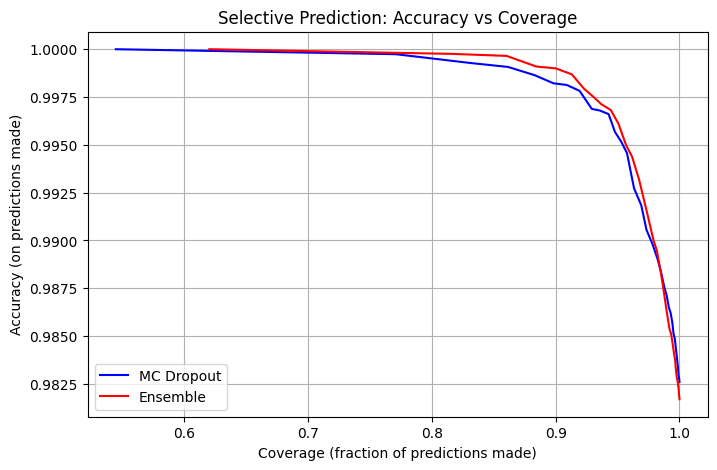

Observation: By abstaining on uncertain samples, we can achieve higher accuracy


In [61]:
# Solution 2: Uncertainty-Aware Prediction (Selective Prediction)
# def selective_prediction(model, loader, thresholds, n_samples=30):
#     """Evaluate accuracy at different coverage levels."""
#     all_preds, all_labels, all_entropy = [], [], []
    
#     for x, y in loader:
#         x = x.to(device)
#         if hasattr(model, 'predict_with_uncertainty'):
#             probs, entropy = model.predict_with_uncertainty(x, n_samples=n_samples)
#         else:
#             _, entropy, _ = model.predict_with_uncertainty(x)
#             probs = _
        
#         preds = probs.argmax(dim=1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(y.numpy())
#         all_entropy.extend(entropy.cpu().numpy())
    
#     all_preds = np.array(all_preds)
#     all_labels = np.array(all_labels)
#     all_entropy = np.array(all_entropy)
    
#     results = []
#     for thresh in thresholds:
#         # Only predict when entropy < threshold
#         mask = all_entropy < thresh
#         coverage = mask.mean()
#         if coverage > 0:
#             accuracy = (all_preds[mask] == all_labels[mask]).mean()
#         else:
#             accuracy = 0
#         results.append((coverage, accuracy))
    
#     return results


def selective_prediction(model, loader, thresholds, n_samples=30):
    """Evaluate accuracy at different coverage levels."""
    all_preds, all_labels, all_entropy = [], [], []
    
    for x, y in loader:
        x = x.to(device)
        if hasattr(model, 'predict_with_uncertainty'):
            # Check if it's MCDropoutNet (accepts n_samples) or DeepEnsemble (doesn't)
            import inspect
            sig = inspect.signature(model.predict_with_uncertainty)
            
            if 'n_samples' in sig.parameters:
                # MCDropoutNet: returns (probs, entropy, variance)
                probs, entropy, _ = model.predict_with_uncertainty(x, n_samples=n_samples)
            else:
                # DeepEnsemble: returns (probs, entropy, variance) or similar
                result = model.predict_with_uncertainty(x)
                if len(result) == 3:
                    probs, entropy, _ = result
                elif len(result) == 2:
                    probs, entropy = result
                else:
                    probs = result[0]
                    entropy = result[1]
        else:
            # Fallback: compute predictions and entropy manually
            with torch.no_grad():
                probs = F.softmax(model(x), dim=1)
                entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1)
        
        preds = probs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.numpy())
        all_entropy.extend(entropy.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_entropy = np.array(all_entropy)
    
    results = []
    for thresh in thresholds:
        # Only predict when entropy < threshold
        mask = all_entropy < thresh
        coverage = mask.mean()
        if coverage > 0:
            accuracy = (all_preds[mask] == all_labels[mask]).mean()
        else:
            accuracy = 0
        results.append((coverage, accuracy))
    
    return results

thresholds = np.linspace(0.01, 2.5, 50)
results_mc = selective_prediction(mc_model, test_loader, thresholds)
results_ens = selective_prediction(ensemble, test_loader, thresholds)

coverages_mc, accs_mc = zip(*results_mc)
coverages_ens, accs_ens = zip(*results_ens)

plt.figure(figsize=(8, 5))
plt.plot(coverages_mc, accs_mc, 'b-', label='MC Dropout')
plt.plot(coverages_ens, accs_ens, 'r-', label='Ensemble')
plt.xlabel('Coverage (fraction of predictions made)')
plt.ylabel('Accuracy (on predictions made)')
plt.title('Selective Prediction: Accuracy vs Coverage')
plt.legend()
plt.grid(True)
plt.show()

print("Observation: By abstaining on uncertain samples, we can achieve higher accuracy")

In [62]:
# Solution 3: Active Learning Simulation
def active_learning_experiment(train_data, test_loader, n_initial=100, n_rounds=10, n_per_round=100):
    """Compare uncertainty sampling vs random sampling."""
    n_total = len(train_data)
    
    # Initial random subset
    all_indices = list(range(n_total))
    np.random.shuffle(all_indices)
    
    labeled_random = all_indices[:n_initial].copy()
    labeled_uncertainty = all_indices[:n_initial].copy()
    pool_random = all_indices[n_initial:].copy()
    pool_uncertainty = all_indices[n_initial:].copy()
    
    results_random, results_uncertainty = [], []
    
    for round_idx in range(n_rounds):
        # Train model on current labeled set - Random
        model_r = SimpleNet().to(device)
        opt_r = torch.optim.Adam(model_r.parameters(), lr=1e-3)
        loader_r = DataLoader(Subset(train_data, labeled_random), batch_size=64, shuffle=True)
        
        for _ in range(10):
            for x, y in loader_r:
                x, y = x.to(device), y.to(device)
                loss = F.cross_entropy(model_r(x), y)
                opt_r.zero_grad()
                loss.backward()
                opt_r.step()
        
        # Evaluate
        model_r.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                pred = model_r(x).argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        results_random.append(correct / total)
        
        # Train model - Uncertainty
        model_u = MCDropoutNet(dropout_p=0.2).to(device)
        opt_u = torch.optim.Adam(model_u.parameters(), lr=1e-3)
        loader_u = DataLoader(Subset(train_data, labeled_uncertainty), batch_size=64, shuffle=True)
        
        for _ in range(10):
            model_u.train()
            for x, y in loader_u:
                x, y = x.to(device), y.to(device)
                loss = F.cross_entropy(model_u(x), y)
                opt_u.zero_grad()
                loss.backward()
                opt_u.step()
        
        # Evaluate
        model_u.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                pred = model_u(x).argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        results_uncertainty.append(correct / total)
        
        # Select next samples
        if len(pool_random) >= n_per_round:
            # Random: just take next n
            selected_r = pool_random[:n_per_round]
            pool_random = pool_random[n_per_round:]
            labeled_random.extend(selected_r)
            
            # Uncertainty: compute entropy on pool
            pool_loader = DataLoader(Subset(train_data, pool_uncertainty), batch_size=128)
            entropies = []
            for x, _ in pool_loader:
                x = x.to(device)
                _, ent = model_u.predict_with_uncertainty(x, n_samples=10)
                entropies.extend(ent.cpu().numpy())
            
            # Select highest entropy
            top_indices = np.argsort(entropies)[-n_per_round:]
            selected_u = [pool_uncertainty[i] for i in top_indices]
            pool_uncertainty = [p for i, p in enumerate(pool_uncertainty) if i not in top_indices]
            labeled_uncertainty.extend(selected_u)
        
        print(f"Round {round_idx+1}: Random={results_random[-1]:.4f}, Uncertainty={results_uncertainty[-1]:.4f}")
    
    return results_random, results_uncertainty

# Run experiment (reduced for speed)
results_r, results_u = active_learning_experiment(mnist_train, test_loader, 
                                                   n_initial=100, n_rounds=5, n_per_round=200)

plt.figure(figsize=(8, 5))
x_axis = [100 + i*200 for i in range(len(results_r))]
plt.plot(x_axis, results_r, 'b-o', label='Random Sampling')
plt.plot(x_axis, results_u, 'r-o', label='Uncertainty Sampling')
plt.xlabel('Number of labeled samples')
plt.ylabel('Test Accuracy')
plt.title('Active Learning: Uncertainty vs Random Sampling')
plt.legend()
plt.grid(True)
plt.show()

ValueError: too many values to unpack (expected 2)